In [63]:
import steps.model as smodel
import steps.geom as swm
import steps.rng as srng
import steps.solver as ssolver
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import N_A


####################################################################################################################################
# instantiate the model:
mdl = smodel.Model()

####################################################################################################################################
# instantiate SPECIES (HERE ONLY CA2+ AND THREE CA2+ BUFFERS):
Ca = smodel.Spec('Ca', mdl)                # Ca2+

CBhi = smodel.Spec('CBhi', mdl)         # CALBINDIN 1 (D-28K) (we consider the 2 (hi-aff) : 2 (lo-aff) scenario)
CBhi_Ca = smodel.Spec('CBhi_Ca', mdl)   # Binding Kinetics of Calbindin-D28k Determined by Flash Photolysis of Caged Ca2 (Nägerl 2000)
CBhi_2Ca = smodel.Spec('CBhi_2Ca', mdl)
CBlo = smodel.Spec('CBlo', mdl)
CBlo_Ca = smodel.Spec('CBlo_Ca', mdl)
CBlo_2Ca = smodel.Spec('CBlo_2Ca', mdl)

PV = smodel.Spec('PV', mdl)            # PARVALBUMIN (Parvalbumin: two EF-hand type Ca2+-binding sites (https://doi.org/10.1016/S0006-3495(02)75472-6))
PV_Ca = smodel.Spec('PV_Ca', mdl)
PV_2Ca = smodel.Spec('PV_2Ca', mdl)

# CALRETININ (CALBINDIN 2)
CR1     = smodel.Spec('CR1', mdl)        # 1st pair of cooperative binding sites
CR1_Ca  = smodel.Spec('CR1_Ca', mdl)
CR1_2Ca = smodel.Spec('CR1_2Ca', mdl)
CR2     = smodel.Spec('CR2', mdl)        # 2nd pair of cooperative binding sites
CR2_Ca  = smodel.Spec('CR2_Ca', mdl)
CR2_2Ca = smodel.Spec('CR2_2Ca', mdl)
CRind     = smodel.Spec('CRind', mdl)
CRind_Ca  = smodel.Spec('CRind_Ca', mdl) # independent binding site


####################################################################################################################################
# instantiate a volume system (a VS groups together different reaction and diffusion rules):
vsys = smodel.Volsys('vsys', mdl)

####################################################################################################################################
CaInflux = smodel.Reac('CaInflux', vsys, rhs=[Ca], kcst=0)
####################################################################################################################################
# DEFINE REACTIONS: Here we assign reactions to a volume system, so that it doesn't just happen anywhere but in a specific volume.

# We assign a reaction to a volume system, define the left and right sides a k const):
# PV <-> PV_Ca <-> PV_2Ca (PV has to Ca2+ binding sites):
"""
k_on, k_off are taken from Lee (2000) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269947/ (See fig. 4)
"""
kreac_f_PV_Ca = smodel.Reac('kreac_f_PV_Ca', vsys, lhs=[PV, Ca], rhs=[PV_Ca], kcst=107e6)
kreac_b_PV_Ca = smodel.Reac('kreac_b_PV_Ca', vsys, lhs=[PV_Ca], rhs=[PV, Ca], kcst=0.95)

kreac_f_PV_2Ca = smodel.Reac('kreac_f_PV_2Ca', vsys, lhs=[PV_Ca, Ca], rhs=[PV_2Ca], kcst=107e6)
kreac_b_PV_2Ca = smodel.Reac('kreac_b_PV_2Ca', vsys, lhs=[PV_2Ca], rhs=[PV_Ca, Ca], kcst=0.95)

####################################################################################################################################
# CALBINDIN 1 (D-28K) HAS FOUR CA BINDING SITES (10.1107/S2059798318011610)

# Kinetics data: U. Valentin Nägerl,* David Novo,† Istvan Mody,† and Julio L. Vergara† (2000)
# We consider a configuration with 2 high affinity : 2 low affinity sites

kreac_f_CBhi_Ca = smodel.Reac('kreac_f_CBhi_Ca', vsys, lhs = [CBhi, Ca], rhs = [CBhi_Ca], kcst = 1.1e7)
kreac_b_CBhi_Ca = smodel.Reac('kreac_b_CBhi_Ca', vsys, lhs = [CBhi_Ca], rhs = [CBhi, Ca], kcst = 2.607)

kreac_f_CBhi_2Ca = smodel.Reac('kreac_f_CBhi_2Ca', vsys, lhs = [CBhi_Ca, Ca], rhs = [CBhi_2Ca], kcst = 1.1e7)
kreac_b_CBhi_2Ca = smodel.Reac('kreac_b_CBhi_2Ca', vsys, lhs = [CBhi_2Ca], rhs = [CBhi_Ca, Ca], kcst = 2.607)

kreac_f_CBlo_Ca = smodel.Reac('kreac_f_CBlo_Ca', vsys, lhs = [CBlo, Ca], rhs = [CBlo_Ca], kcst = 8.7e7)
kreac_b_CBlo_Ca = smodel.Reac('kreac_b_CBlo_Ca', vsys, lhs = [CBlo_Ca], rhs = [CBlo, Ca], kcst = 35.76)

kreac_f_CBlo_2Ca = smodel.Reac('kreac_f_CBlo_2Ca', vsys, lhs = [CBlo_Ca, Ca], rhs = [CBlo_2Ca], kcst = 8.7e7)
kreac_b_CBlo_2Ca = smodel.Reac('kreac_b_CBlo_2Ca', vsys, lhs = [CBlo_2Ca], rhs = [CBlo_Ca, Ca], kcst = 35.76)

##########################################################!!!!!!!!!#########################################################################
# CALRETININ (CALBINDIN 2) HAS 6 EF-hand motifs, 5 of which can bind Ca.
# Sites 1 and 2 form a cooperative pair, as do sites 3 and 4. Site 5 is an independent Ca-binding site.
# a binding site is in the T state when the other binding site has no Ca2þ bound,
# 
kreac_f_CR1_Ca = smodel.Reac('kreac_f_CR1_Ca', vsys, lhs = [CR1, Ca], rhs = [CR1_Ca], kcst=2*1.8e6) # kcst = 43.5e6
kreac_b_CR1_Ca = smodel.Reac('kreac_b_CR1_Ca', vsys, lhs = [CR1_Ca], rhs = [CR1, Ca], kcst = 53) # kcst = 35.8

kreac_f_CR1_2Ca = smodel.Reac('kreac_f_CR1_2Ca', vsys, lhs = [CR1_Ca, Ca], rhs = [CR1_2Ca], kcst = 3.1e8) # kcst ???? why same
kreac_b_CR1_2Ca = smodel.Reac('kreac_b_CR1_2Ca', vsys, lhs = [CR1_2Ca], rhs = [CR1_Ca, Ca], kcst = 2*20)

kreac_f_CR2_Ca = smodel.Reac('kreac_f_CR2_Ca', vsys, lhs = [CR2, Ca], rhs = [CR2_Ca], kcst = 2*1.8e6) # kcst ???? why same
kreac_b_CR2_Ca = smodel.Reac('kreac_b_CR2_Ca', vsys, lhs = [CR2_Ca], rhs = [CR2, Ca], kcst = 53)

kreac_f_CR2_2Ca = smodel.Reac('kreac_f_CR2_2Ca', vsys, lhs = [CR2_Ca, Ca], rhs = [CR2_2Ca], kcst = 3.1e8) # kcst ???? why same
kreac_b_CR2_2Ca = smodel.Reac('kreac_b_CR2_2Ca', vsys, lhs = [CR2_2Ca], rhs = [CR2_Ca, Ca], kcst = 2*20)

kreac_f_CRind_Ca = smodel.Reac('kreac_f_CRind_Ca', vsys, lhs = [CRind, Ca], rhs = [CRind_Ca], kcst = 7.3e6) # kcst ???? why same
kreac_b_CRind_Ca = smodel.Reac('kreac_b_CRind_Ca', vsys, lhs = [CRind_Ca], rhs = [CRind, Ca], kcst = 252)

####################################################################################################################################
# instantiate a 'hub' compartment:
wmgeom = swm.Geom()
# create a 'comp' compartment (actual geometric entity) in the 'wgeom' entity:
comp = swm.Comp('comp', wmgeom)
# put a previously defined volume system into the compartment and set the volume value:
comp.addVolsys('vsys')
comp.setVol(2.4807243154559652e-20) # 0.005 μm3 to 1.1 μm3, neocortex, pyramidal, (Neuron, https://doi.org/10.1016/j.neuron.2005.01.003)
                                    # 0.0025 um3 in the cortex and cerebellum of Rattus novegicus


# random number generator, buffer size, seed:
r = srng.create('mt19937', 256)
r.initialize(23412)

# instantiate a solver:
sim = ssolver.Wmdirect(mdl, wmgeom, r)

# reset the solver:
sim.reset()

# set initial conditions (concentration, mohl/L):
def set_init_cond(sim):
    """
    Though it seems to be generally accepted that calbindin-D28K (CB) has one very high 
    affinity calcium binding site (Kd •1 nÒ) and two or three lower affinity calcium binding 
    sites (Kd •10 ìÒ) (Gross et al. 1993), the details of the calcium binding properties of CB are not yet known
    """
    sim.setCompConc('comp', 'Ca', 1.6e-6)    # here I was aiming at ~24 ions in the entire volume of the synapse
    
    # total CB in rat HC: 1.98e-6
    sim.setCompConc('comp', 'CBhi', 0.99e-6) # i.e. 1/2 of total CB molarity (1.98*10e-6)
    sim.setCompConc('comp', 'CBhi_Ca', 0)
    sim.setCompConc('comp', 'CBhi_2Ca', 0)
    sim.setCompConc('comp', 'CBlo', 0.99e-6) # i.e. 1/2 of total CB molarity (1.98*10e-6)
    sim.setCompConc('comp', 'CBlo_Ca', 0)
    sim.setCompConc('comp', 'CBlo_2Ca', 0)
    
    # total CR in rat HC: 2.47e-6
    sim.setCompConc('comp', 'CR1', 0.988e-6)   # 2/5 of total CR
    sim.setCompConc('comp', 'CR1_Ca', 0)
    sim.setCompConc('comp', 'CR1_2Ca', 0)
    sim.setCompConc('comp', 'CR2', 0.988e-6)  # 2/5 of total CR
    sim.setCompConc('comp', 'CR2_Ca', 0)
    sim.setCompConc('comp', 'CR2_2Ca', 0)
    sim.setCompConc('comp', 'CRind', 0.494e-6)  # 1/5 of total CR
    sim.setCompConc('comp', 'CRind_Ca', 0)
    
    # total PV in rat HC: 4.55e-6
    sim.setCompConc('comp', 'PV', 4.55e-6)
    sim.setCompConc('comp', 'PV_Ca', 0)
    sim.setCompConc('comp', 'PV_2Ca', 0)
    return sim
sim = set_init_cond(sim)


In [64]:
%matplotlib inline
T = 0.04          # sim time
dt = 0.00001      # delta t
Tp = T/4          # This is when we open Ca2+ channels

# time vector:
time = np.arange(0, T, dt)

def myround(x, base=dt):
    return base * round(x/base)

# simulate for NITER times every timestep (to smooth out the jitter):
NITER = 30
output = np.zeros([NITER, len(time), sim.getNCompSpecs(0)])


for i in range(0, NITER):
    sim.reset()
    sim = set_init_cond(sim)
    c = 0
    for t in np.arange(0, T, dt):
        sim.run(t)
        if t == myround(Tp, base=dt):
#             sim.setCompCount('comp', 'Ca', sim.getCompCount('comp', 'Ca') + 10)
            sim.setCompReacK('comp','CaInflux', 2.15134760106791e-3)
        if t == myround(Tp, base=dt)+0.0025:
            sim.setCompReacK('comp','CaInflux', 0) 
        for j in range(sim.getNCompSpecs(0)):
            output[i, c, j] = sim.getCompCount('comp', sim.getCompSpecName(0, j).decode("utf-8"))
        c += 1
out_mean = np.mean(output, axis=0)

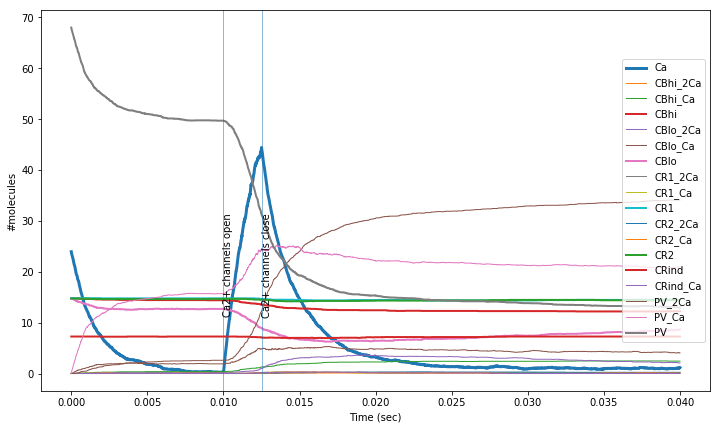

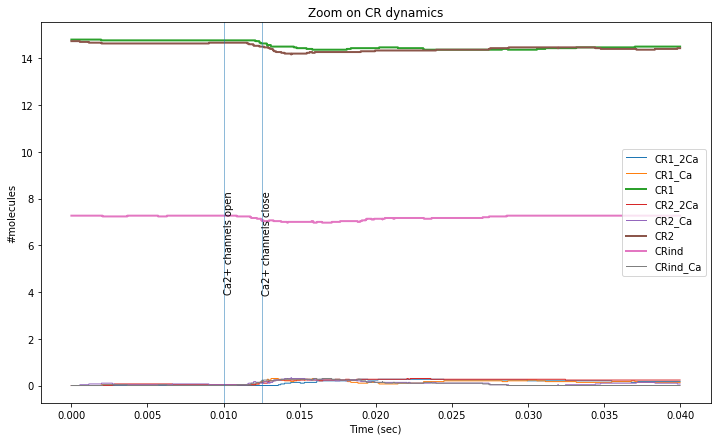

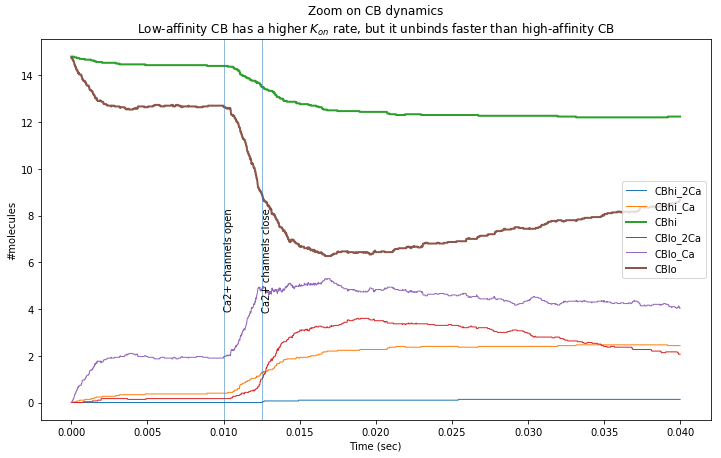

In [66]:
plt.figure(figsize=(12,7))
highlight = ['Ca', 'CR1', 'CR2', 'CRind', 'CBlo', 'CBhi', 'PV']
for j in range(sim.getNCompSpecs(0)):
    spec_name = sim.getCompSpecName(0, j).decode("utf-8")
    linewidth = 2 if any([spec_name==i for i in highlight]) else 1
    linewidth = 3 if any([spec_name=='Ca']) else linewidth
    plt.plot(time, out_mean[:,j], label = spec_name, linewidth=linewidth)

plt.axvline(x=Tp, linewidth=0.5)
plt.text(Tp,30,'Ca2+ channels open',rotation=90)

plt.axvline(x=0.0125, linewidth=0.5)
plt.text(0.0125,30,'Ca2+ channels close',rotation=90)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')
plt.show()


plt.figure(figsize=(12,7))
plt.title('Zoom on CR dynamics')
highlight = ['Ca', 'CR1', 'CR2', 'CRind']
for j in range(7, 15):
    spec_name = sim.getCompSpecName(0, j).decode("utf-8")
    linewidth = 2 if any([spec_name==i for i in highlight]) else 1
    linewidth = 3 if any([spec_name=='Ca']) else linewidth
    plt.plot(time, out_mean[:,j], label = spec_name, linewidth=linewidth)

plt.axvline(x=Tp, linewidth=0.5)
plt.text(Tp,8,'Ca2+ channels open',rotation=90)

plt.axvline(x=0.0125, linewidth=0.5)
plt.text(0.0125,8,'Ca2+ channels close',rotation=90)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')
plt.show()


plt.figure(figsize=(12,7))
plt.title('Zoom on CB dynamics\n' + 'Low-affinity CB has a higher $K_{on}$ rate, but it unbinds faster than high-affinity CB')
highlight = ['CBlo', 'CBhi']
for j in range(1, 7):
    spec_name = sim.getCompSpecName(0, j).decode("utf-8")
    linewidth = 2 if any([spec_name==i for i in highlight]) else 1
    linewidth = 3 if any([spec_name=='Ca']) else linewidth
    plt.plot(time, out_mean[:,j], label = spec_name, linewidth=linewidth)

plt.axvline(x=Tp, linewidth=0.5)
plt.text(Tp,8,'Ca2+ channels open',rotation=90)

plt.axvline(x=0.0125, linewidth=0.5)
plt.text(0.0125,8,'Ca2+ channels close',rotation=90)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')
plt.show()

# ==============================================
# **NOTES**
## Molar concentration:
$$ \boxed {c = \frac {N}{N_A V}}$$

## Number of molecules in a volume with a given molar concentration (mol/L):
$$ \boxed {N = C N_A V}$$

$$
N = \frac {mol}{L} \frac {1}{mol} \frac {m^3}{1} = \frac {m^3}{L} = \frac {kL}{L} 
$$

## Mole 
### A mole of some substance is always $N_A$ (Avogadro's number of) molecules of that substance, i.e. $6.02214076×10^{23}$ molecules

## equilibrium dissociation constant (KD) - Affinity
#### Binding affinity is typically measured by the equilibrium dissociation constant (KD), which is used to evaluate strengths of bimolecular interactions. **The smaller the KD value, the greater the binding affinity of the ligand for its target.**
$$ \boxed {K_D = \frac {K_{off}} {K_{on}}}$$

# ======================================================
## Let's check the concentration and count of a species:

In [9]:
spec = 'Ca'
V_m3 = comp.getVol()
print('Volume: {} \t(m3)'.format(V_m3))
print('Volume: {} \t(L)'.format(V_m3*10e+3))
C = sim.getCompConc('comp', 'Ca')
N = C * N_A * V_m3 * 1000
print('\nAccording to OUR FORMULA:')
print('This volume contains {:.1f} molecules of {}'.format(N, spec))

print('\nAccording to STEPS sim.getCompCount:')
N = sim.getCompCount('comp', spec)
print('This volume contains {} molecules of {}'.format(N, spec))

Volume: 2.4807243154559652e-20 	(m3)
Volume: 2.480724315455965e-16 	(L)

According to OUR FORMULA:
This volume contains 0.0 molecules of Ca

According to STEPS sim.getCompCount:
This volume contains 0.0 molecules of Ca


In [10]:
"""
LET'S COMPUTE THE VOLUMES OF THE SYNAPSES BASED ON MOLECULES/SYN AND MOLARITY DATA
"""

#CR
mol = 2.47*10e-6
N = 369
print('Avogadro\'s number: ', N_A)
print('synapse volume: {} m3'.format(N/(mol * N_A * 1000)))
print('synapse volume: {} um3'.format(N/(2.47*10e-6 * N_A * 1000 * 10e-18)))
print('\n\n')

#CB
mol = 1.98*10e-6
N = 296
print('Avogadro\'s number: ', N_A)
print('synapse volume: {} m3'.format(N/(mol * N_A * 1000)))
print('synapse volume: {} um3'.format(N/(mol * N_A * 1000 * 10e-18)))

Avogadro's number:  6.022140857e+23
synapse volume: 2.4807243154559652e-20 m3
synapse volume: 0.0024807243154559653 um3



Avogadro's number:  6.022140857e+23
synapse volume: 2.4824219998305082e-20 m3
synapse volume: 0.002482421999830508 um3


In [11]:
from scipy.constants import N_A
print('Avogadro\'s number: ', N_A)

vol = 1.6667e-21
c1 =  31.4e-6
c2 = 22.3e-6

N1 = c1 * N_A * vol * 1000 # we multiply by the 1000 because concentration is in mol/L, while volume is in m3 (i.e. kL)
N2 = c2 * N_A * vol * 1000 # we multiply by the 1000 because concentration is in mol/L, while volume is in m3 (i.e. kL)

print('{:.1f} molecules in {} cubic meters of volume at concentration of {} mol/L'.format(N1, vol, c1))
print('{:.1f} molecules in {} cubic meters of volume at concentration of {} mol/L'.format(N2, vol, c2))

Avogadro's number:  6.022140857e+23
31.5 molecules in 1.6667e-21 cubic meters of volume at concentration of 3.14e-05 mol/L
22.4 molecules in 1.6667e-21 cubic meters of volume at concentration of 2.23e-05 mol/L
